## 1. Background information
The goal of this notebook is to develop and compare different supervised machine learning (ML) algorithms, aiming to calibrate the data captured from the Microsoft Azure kinect system with the data captured from the Captiv system. The reason is that the Kinect system suffers from occlusion issues due to its field-of-view limitation, thus it may generate artifacts during recording, and may impact the final ergonomic evaluation results. Captiv system uses inertial measurement units, thus does not have occlusion issues. We therefore want to use the data generated by Captiv system as benchmark, and calibrate the Kinect data to that of Captiv data.
We used both Azure Kinect and Captiv L7000 to record motion data. Data from 8 participants were collected. Each participant perform packaging task in our lab for around 10 minutes. Both types of motion tracking systems have a frame rate of 30, therefore, for each participant, approximately 30*10*60=18000 frames were generated during recording. Captiv system export angle related data, taking BACK as an example, it generates back forward flexion angle. The Azure Kinect however generates the coordinates, rotation, and joint angle data of body joints. Therefore, for each recorded frame, the following observations are involved:
- Angle Back Forward flexion_Captiv
- Spine_global_position_X
- Spine_global_position_Y
- Spine_global_position_Z
- Spine_global_rotation_X
- Spine_global_rotation_Y
- Spine_global_rotation_Z
- Neck_global_position_X
- Neck_global_position_Y
- Neck_global_position_Z
- Neck_global_rotation_X
- Neck_global_rotation_Y
- Neck_global_rotation_Z
- Back_Forward_Flexion_Kinect

## 2. Data preparation

In [1]:
# Import standard packages. We import modeling packages later when we first need them.
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Load data
motiondata = pd.read_csv('D:/Data_Lab_22.08.2024/data_captiv_kinect.csv')
motiondata.head()

,Angle Back Forward flexion,Back_Forward_Flexion,Neck_global_position_X,Neck_global_position_Y,Neck_global_position_Z,Neck_global_rotation_X,Neck_global_rotation_Y,Neck_global_rotation_Z,Spine_global_position_X,Spine_global_position_Y,Spine_global_position_Z,Spine_global_rotation_X,Spine_global_rotation_Y,Spine_global_rotation_Z
0,6.256031,5.699111,-0.330780,1.462088,0.004155,0.535413,2.905215,-1.828663,-0.338609,1.220949,0.026911,-5.117317,6.241200,-2.553483
1,5.768875,5.718391,-0.325316,1.462714,0.004790,0.558822,3.053484,-2.287191,-0.334374,1.221582,0.027173,-5.015078,6.073301,-2.785719
2,5.343807,5.747210,-0.319543,1.463814,0.005402,0.630216,3.277100,-2.774031,-0.329924,1.222642,0.027343,-4.900522,5.930052,-3.042788
3,5.318164,5.752422,-0.313476,1.465038,0.006348,0.821774,3.607527,-3.245410,-0.325250,1.223800,0.027607,-4.739885,5.863819,-3.324815
4,5.586848,5.762666,-0.307141,1.466117,0.007574,1.090560,4.160373,-3.720130,-0.320400,1.224820,0.027999,-4.552147,5.964506,-3.644244


In [3]:
# Overview of the data
print('Dimensionality of the data is {}'.format(motiondata.shape))
motiondata.info()

Dimensionality of the data is (147626, 14)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 147626 entries, 0 to 147625
Data columns (total 14 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   Angle Back Forward flexion  147626 non-null  float64
 1   Back_Forward_Flexion        147626 non-null  float64
 2   Neck_global_position_X      147626 non-null  float64
 3   Neck_global_position_Y      147626 non-null  float64
 4   Neck_global_position_Z      147626 non-null  float64
 5   Neck_global_rotation_X      147626 non-null  float64
 6   Neck_global_rotation_Y      147626 non-null  float64
 7   Neck_global_rotation_Z      147626 non-null  float64
 8   Spine_global_position_X     147626 non-null  float64
 9   Spine_global_position_Y     147626 non-null  float64
 10  Spine_global_position_Z     147626 non-null  float64
 11  Spine_global_rotation_X     147626 non-null  float64
 12  Spine_global_rotation_Y     1

In [3]:
# Given that all the variables are numerical ones, we now transform the values into float32 format to save memory consumption.
num_vars = motiondata.select_dtypes(include=np.float64).columns
motiondata[num_vars] = motiondata[num_vars].astype(np.float32)
motiondata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 147626 entries, 0 to 147625
Data columns (total 14 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   Angle Back Forward flexion  147626 non-null  float32
 1   Back_Forward_Flexion        147626 non-null  float32
 2   Neck_global_position_X      147626 non-null  float32
 3   Neck_global_position_Y      147626 non-null  float32
 4   Neck_global_position_Z      147626 non-null  float32
 5   Neck_global_rotation_X      147626 non-null  float32
 6   Neck_global_rotation_Y      147626 non-null  float32
 7   Neck_global_rotation_Z      147626 non-null  float32
 8   Spine_global_position_X     147626 non-null  float32
 9   Spine_global_position_Y     147626 non-null  float32
 10  Spine_global_position_Z     147626 non-null  float32
 11  Spine_global_rotation_X     147626 non-null  float32
 12  Spine_global_rotation_Y     147626 non-null  float32
 13  Spine_global_r

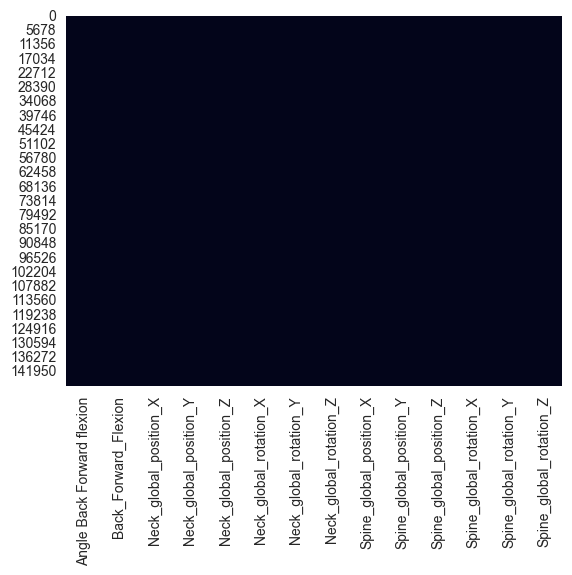

In [5]:
# Check whether there are any missing values
motiondata.isnull().sum().sum()
sns.heatmap(motiondata.isnull(), cbar=False);

We don't get any missing values here. Because before loading the data, the data has already been cleaned and synchronised. In addition, both systems are reliable in terms of data recording, therefore, it rarely misses values.

## 3. Exploratory data analysis

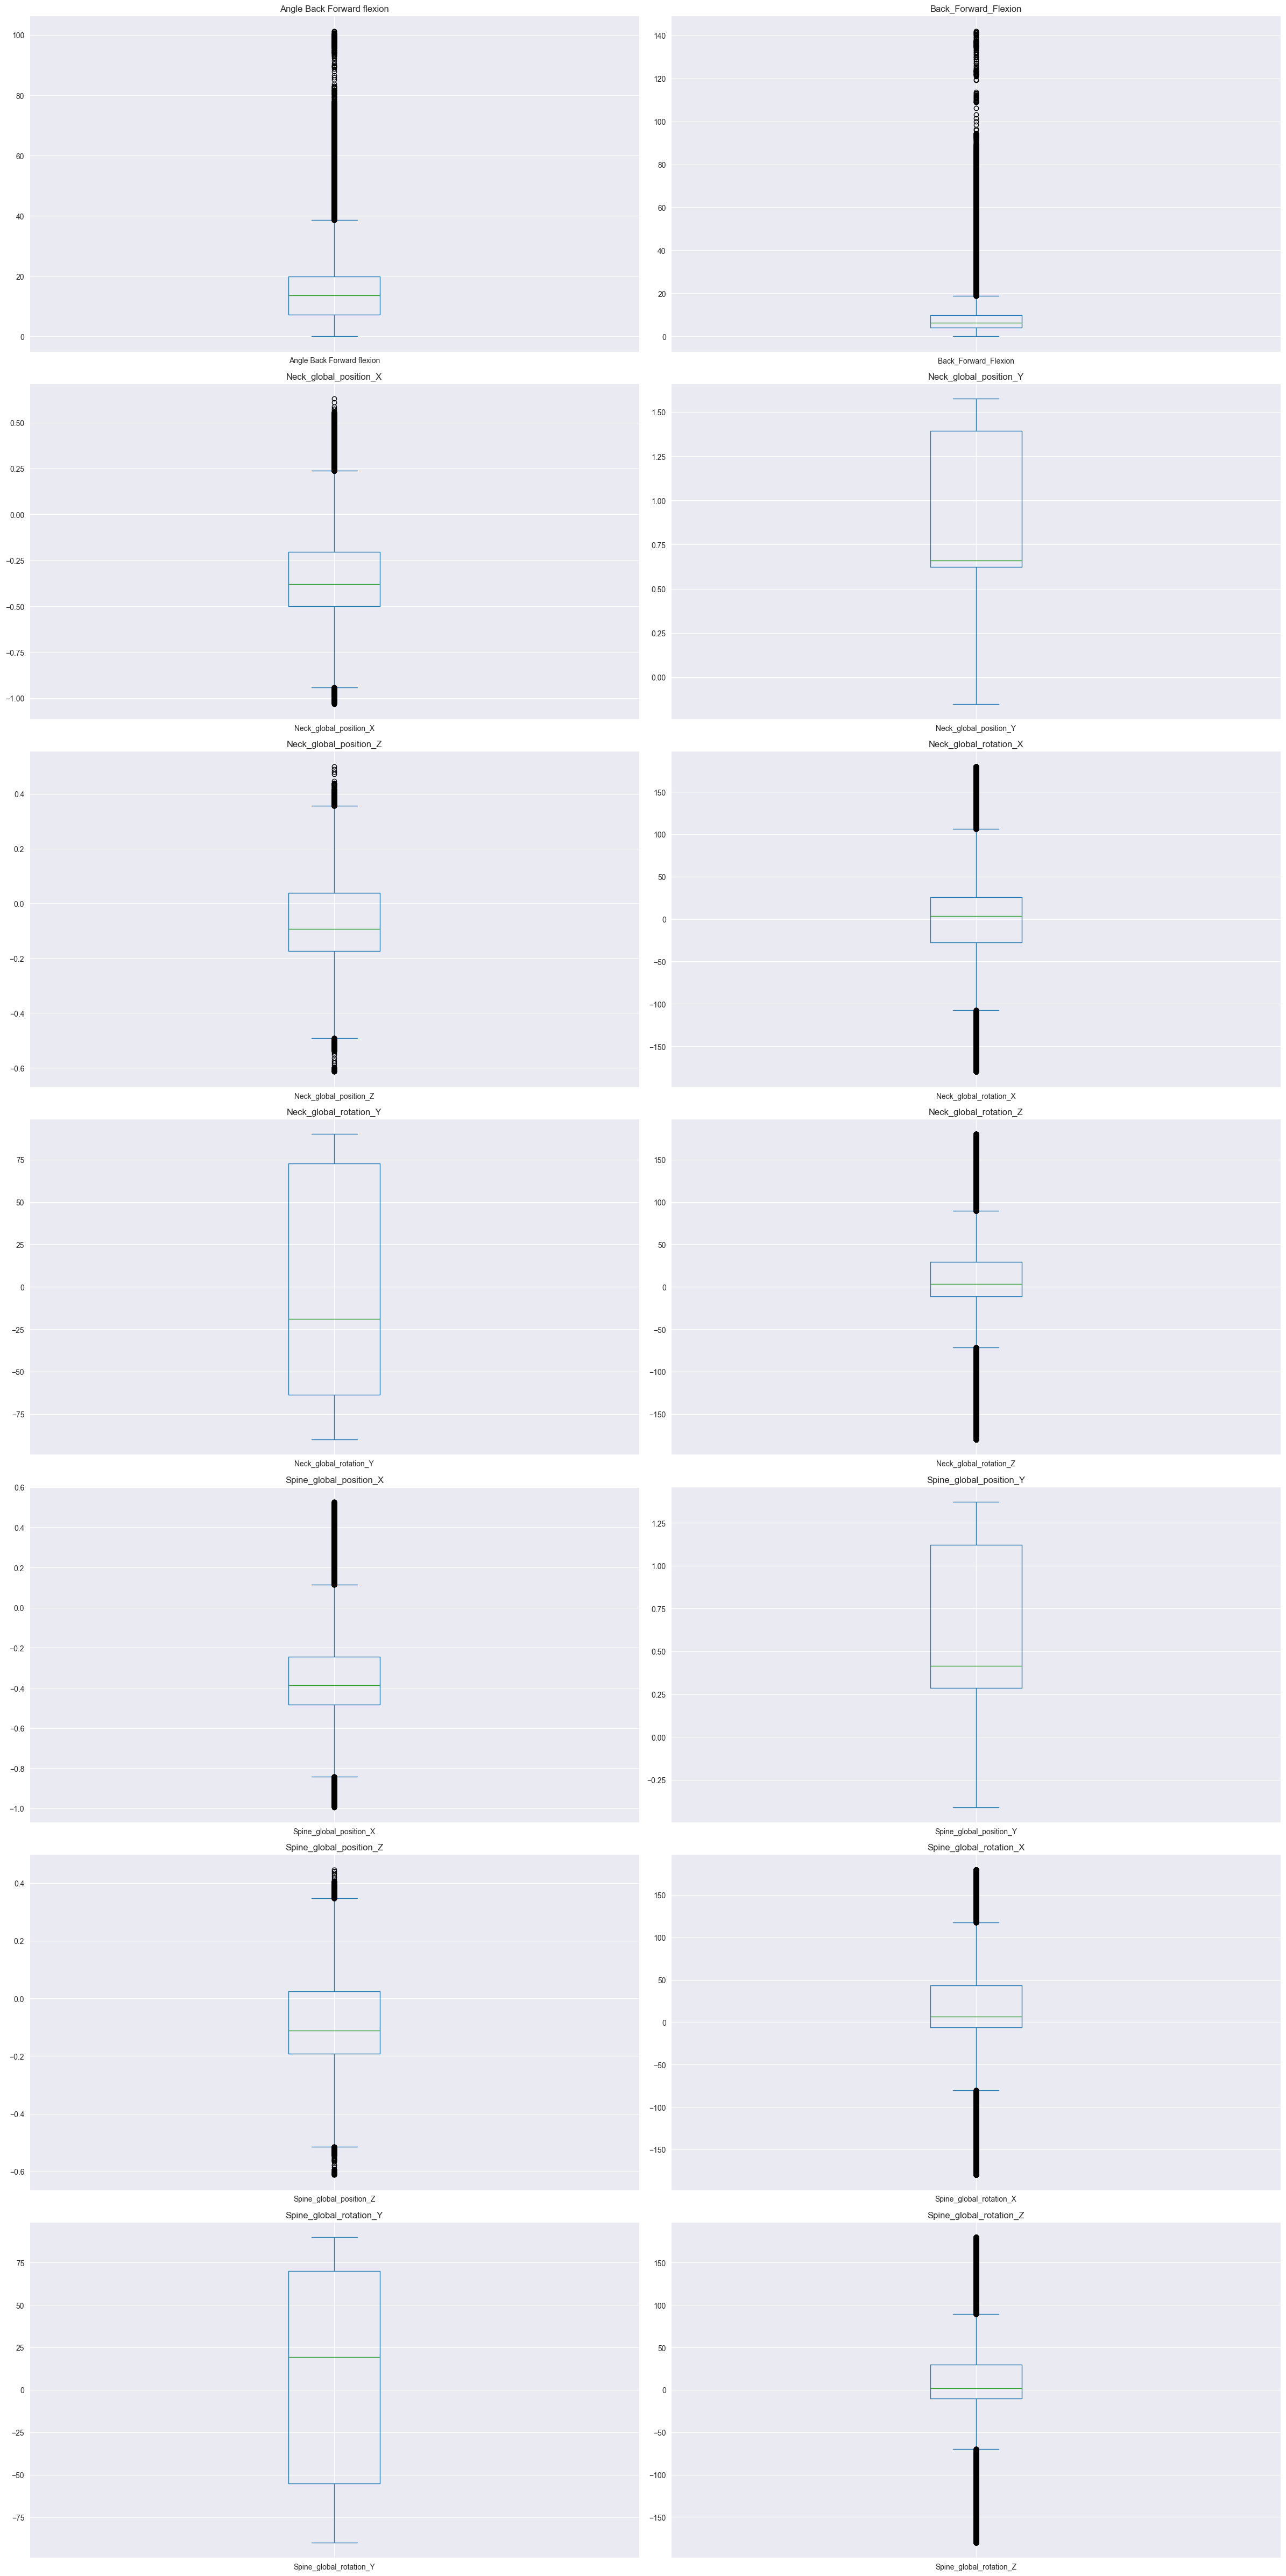

In [6]:
# We generate box plots for the numerical variables
num_vars = motiondata.select_dtypes(include="float32")
half = np.ceil(num_vars.shape[1] / 2).astype(int)
fig, axes = plt.subplots(half, 2, figsize=(24, 48))

axes = axes.ravel()

for i, col in enumerate(num_vars.columns):
    num_vars[col].plot(kind='box', ax=axes[i])
    axes[i].set_title(col)
    axes[i].tick_params(axis='x')

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


From the boxplot, we can see that the angle generated from Captiv system and Kinect system differs, with different median and variations. Captiv system is treated as golden standard, therefore there is no outlier for the Captiv data. For the Kinect system, there are so-called artifacts, and this is the reason we want to use ML to correct these artifacts. Also, given that the median of two systems are different, we want to try different ML to test whether the data of Kinect system can be calibrated to that of Captiv one.

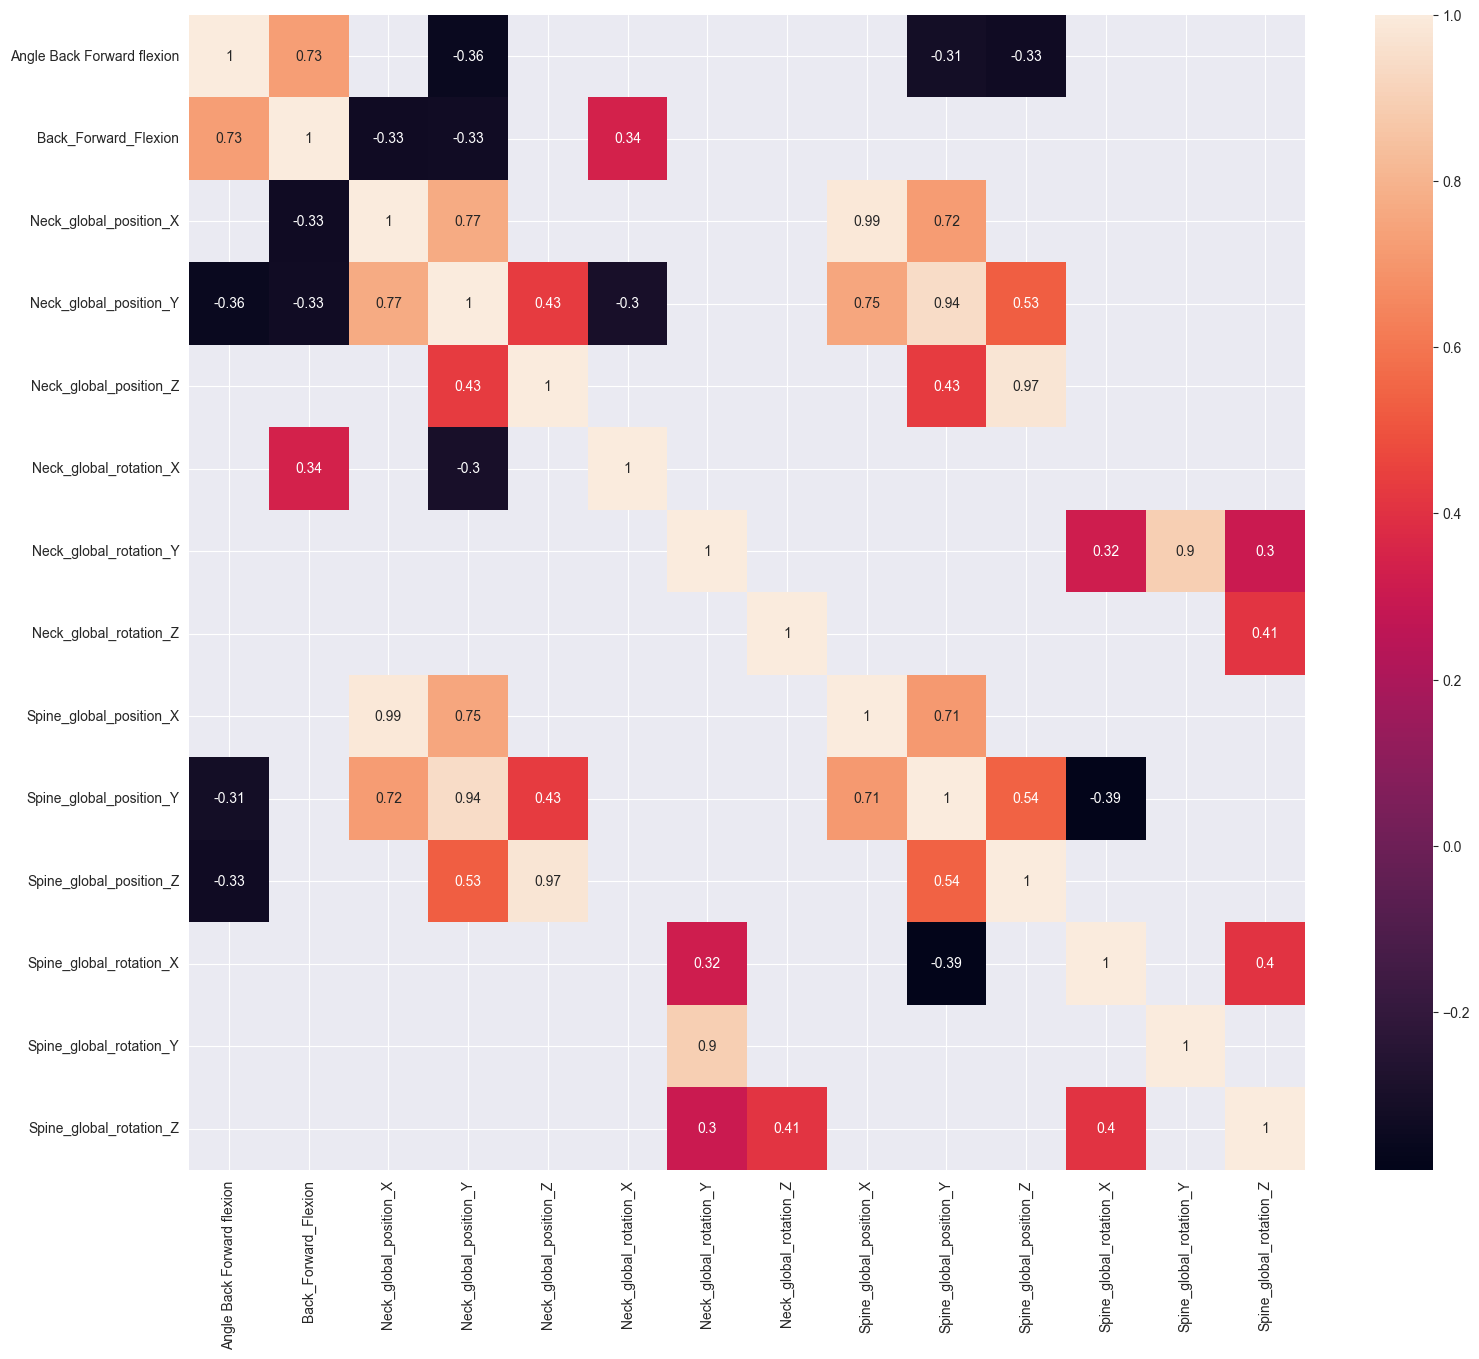

In [7]:
# Correlation analysis, considering the threshold as 0.3
corr= motiondata.corr()
f,ax = plt.subplots(figsize=(18, 15))
sns.heatmap(corr[(corr >= 0.30) | (corr <= -0.30)],
            annot=True);

The values shown here are reasonable. Because the back forward flexion is calculated using the "neck" coordinates and "spine" coordinates, therefore it shows higher correlation between the neck position/rotation and spine position/rotation. Also, the correlation between Kinect back forward flexion and Captiv back forward flexion is predictable.

In [8]:
# Save data
motiondata.to_csv('motiondata_modeling.csv')

In [4]:
# Extract y and X
X = motiondata.copy()
y = X.pop('Angle Back Forward flexion')  # extract target variable from data frame, in this case, the data of Captiv system
X.head()

,Back_Forward_Flexion,Neck_global_position_X,Neck_global_position_Y,Neck_global_position_Z,Neck_global_rotation_X,Neck_global_rotation_Y,Neck_global_rotation_Z,Spine_global_position_X,Spine_global_position_Y,Spine_global_position_Z,Spine_global_rotation_X,Spine_global_rotation_Y,Spine_global_rotation_Z
0,5.699111,-0.330780,1.462088,0.004155,0.535413,2.905215,-1.828663,-0.338609,1.220949,0.026911,-5.117317,6.241200,-2.553483
1,5.718391,-0.325316,1.462714,0.004790,0.558822,3.053484,-2.287191,-0.334374,1.221582,0.027173,-5.015078,6.073301,-2.785719
2,5.747210,-0.319543,1.463814,0.005402,0.630216,3.277100,-2.774031,-0.329924,1.222642,0.027343,-4.900522,5.930052,-3.042788
3,5.752422,-0.313476,1.465038,0.006348,0.821774,3.607527,-3.245410,-0.325250,1.223800,0.027607,-4.739885,5.863819,-3.324815
4,5.762666,-0.307141,1.466117,0.007574,1.090560,4.160373,-3.720130,-0.320400,1.224820,0.027999,-4.552147,5.964506,-3.644244


In [5]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2 )  # select 20% of the data as hold-out

y_train.shape, x_train.shape, y_test.shape, x_test.shape

((118100,), (118100, 13), (29526,), (29526, 13))

## 4. ML using linear regression and Lasso

4.1 First, we try using the linear regression with cross-validation (Number of folds = 5)

In [12]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm

In [15]:
# Setup cross-validation and data structures to store results
nfold = 5
results_cv = list()
cv = KFold(n_splits=nfold, shuffle=True, random_state=42)

cv_mse_test = np.zeros(nfold)  # Store MSE for test sets
cv_mse_train = np.zeros(nfold)  # Store MSE for train sets

# Prepare a dictionary to store MSE values for all models
mse_results_lr = {'Model': [], 'Fold': [], 'MSE_Train': [], 'MSE_Test': []}

plt.figure(figsize=[8, 6])

print("Cross-validating the linear regression model:")

for i, (tr_idx, vl_idx) in enumerate(cv.split(X, y)):
    # Split data into training and validation sets
    xtr, xvl = X.iloc[tr_idx], X.iloc[vl_idx]
    ytr, yvl = y.iloc[tr_idx], y.iloc[vl_idx]
    xtr_sm = sm.add_constant(xtr)
    xvl_sm = sm.add_constant(xvl)

    # Train the linear regression model
    model = sm.OLS(ytr, xtr_sm).fit()
    print(f"Summary for Fold {i + 1}:\n", model.summary())

    # Predictions for the validation set
    yvl_pred = model.predict(xvl_sm)

    # Predictions for the training set
    ytr_pred = model.predict(xtr_sm)

    # Compute MSE for train and test sets
    mse_test = mean_squared_error(yvl, yvl_pred)
    mse_train = mean_squared_error(ytr, ytr_pred)

    # Store MSE results for Linear Regression
    mse_results_lr['Model'].append('Linear Regression')
    mse_results_lr['Fold'].append(i + 1)
    mse_results_lr['MSE_Train'].append(mse_train)
    mse_results_lr['MSE_Test'].append(mse_test)

    print(f"\tFold {i + 1}: MSE on Test Set = {mse_test:.4f}, MSE on Train Set = {mse_train:.4f}")

plt.show()

# Convert the mse_results dictionary for Linear Regression to a DataFrame for easy viewing
mse_df_lr = pd.DataFrame(mse_results_lr)

# Display the MSE results for Linear Regression
print("\nMSE Results for Linear Regression:")
print(mse_df_lr)

# Compute and display average MSE across all folds
average_mse_train = np.mean(mse_df_lr['MSE_Train'])
average_mse_test = np.mean(mse_df_lr['MSE_Test'])

print(f"\nAverage MSE on Train Set: {average_mse_train:.4f}")
print(f"Average MSE on Test Set: {average_mse_test:.4f}")



Cross-validating the linear regression model:
Summary for Fold 1:
                                 OLS Regression Results                                
Dep. Variable:     Angle Back Forward flexion   R-squared:                       0.687
Model:                                    OLS   Adj. R-squared:                  0.687
Method:                         Least Squares   F-statistic:                 1.994e+04
Date:                        Sat, 30 Nov 2024   Prob (F-statistic):               0.00
Time:                                16:41:36   Log-Likelihood:            -4.0577e+05
No. Observations:                      118100   AIC:                         8.116e+05
Df Residuals:                          118086   BIC:                         8.117e+05
Df Model:                                  13                                         
Covariance Type:                    nonrobust                                         
                              coef    std err          t      P

<Figure size 800x600 with 0 Axes>


MSE Results for Linear Regression:
               Model  Fold  MSE_Train   MSE_Test
0  Linear Regression     1  56.469092  56.307975
1  Linear Regression     2  56.639029  55.628874
2  Linear Regression     3  56.341990  56.814567
3  Linear Regression     4  56.248982  57.193849
4  Linear Regression     5  56.469097  56.317333

Average MSE on Train Set: 56.4336
Average MSE on Test Set: 56.4525


The results look already good, with adjusted R square of 0.68. The MSE for test set is just a little bit larger than training set.

In [16]:
# Check whether there is multicollinearity
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [17]:
# Add a constant to the feature matrix for calculating VIF
X_with_const = sm.add_constant(X)

# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data["Feature"] = X_with_const.columns
vif_data["VIF"] = [variance_inflation_factor(X_with_const.values, i) for i in range(X_with_const.shape[1])]

print(vif_data)


                    Feature         VIF
0                     const   58.509316
1      Back_Forward_Flexion    3.003387
2    Neck_global_position_X  104.234932
3    Neck_global_position_Y   21.241682
4    Neck_global_position_Z   48.048229
5    Neck_global_rotation_X    1.432097
6    Neck_global_rotation_Y    9.138887
7    Neck_global_rotation_Z    1.341114
8   Spine_global_position_X  102.828964
9   Spine_global_position_Y   17.636369
10  Spine_global_position_Z   54.424439
11  Spine_global_rotation_X    1.783884
12  Spine_global_rotation_Y    8.231798
13  Spine_global_rotation_Z    1.901481


From the VIF results, it proves the above assumption, that the coordinates data of neck and spine are highly correlated, with values all larger than 10. However, the goal was to make prediction instead of explanation. In the next, I want to try Lasso to test whether there is any improvement of the model.

In [10]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import mean_squared_error, r2_score

4.2 We now try using Lasso

In [11]:
# Define the hyperparameter grid for alpha
lasso = Lasso(alpha=0.1, max_iter=3000, fit_intercept=True)
alpha_settings = {'alpha': [0.001, 0.003, 0.005, 0.01, 0.03, 0.05, 0.1, 0.3, 0.5, 1.0]}

# Set up cross-validation
nfold = 5
kf = KFold(n_splits=nfold, shuffle=True, random_state=42)

# Prepare a dictionary to store MSE values during cross-validation
mse_results_lasso = {'Model': [], 'Fold': [], 'MSE_Train': [], 'MSE_Test': []}

# Perform grid search to find best alpha
gs_lasso = GridSearchCV(lasso, alpha_settings, scoring='neg_mean_squared_error', cv=kf, refit=True)
gs_lasso.fit(x_train, y_train)

# Retrieve the best model and its alpha
best_lasso = gs_lasso.best_estimator_
best_alpha = gs_lasso.best_params_['alpha']

print(f"Best alpha from grid search: {best_alpha:.4f}")

# Cross-validation to calculate MSE for each fold
print("Cross-validating the Lasso model:")

for i, (tr_idx, vl_idx) in enumerate(kf.split(x_train, y_train)):
    # Split data into training and validation sets
    xtr, xvl = x_train.iloc[tr_idx], x_train.iloc[vl_idx]
    ytr, yvl = y_train.iloc[tr_idx], y_train.iloc[vl_idx]

    # Train the Lasso model
    lasso_model = Lasso(alpha=best_alpha, max_iter=3000, fit_intercept=True)
    lasso_model.fit(xtr, ytr)

    # Predictions for the validation set
    yvl_pred = lasso_model.predict(xvl)

    # Predictions for the training set
    ytr_pred = lasso_model.predict(xtr)

    # Compute MSE for train and test sets
    mse_test = mean_squared_error(yvl, yvl_pred)
    mse_train = mean_squared_error(ytr, ytr_pred)

    # Store MSE results for Lasso
    mse_results_lasso['Model'].append('Lasso')
    mse_results_lasso['Fold'].append(i + 1)
    mse_results_lasso['MSE_Train'].append(mse_train)
    mse_results_lasso['MSE_Test'].append(mse_test)

    print(f"\tFold {i + 1}: MSE on Test Set = {mse_test:.4f}, MSE on Train Set = {mse_train:.4f}")

plt.show()

# Convert the mse_results dictionary for Lasso to a DataFrame for easy viewing
mse_df_lasso = pd.DataFrame(mse_results_lasso)

# Display the MSE results for Lasso
print("\nMSE Results for Lasso:")
print(mse_df_lasso)

# Compute and display average MSE across all folds
average_mse_train_lasso = np.mean(mse_df_lasso['MSE_Train'])
average_mse_test_lasso = np.mean(mse_df_lasso['MSE_Test'])

print(f"\nAverage MSE on Train Set: {average_mse_train_lasso:.4f}")
print(f"Average MSE on Test Set: {average_mse_test_lasso:.4f}")

# Predict using the best model from Grid Search (using the entire training data)
y_pred_best = best_lasso.predict(x_test)

# Compute metrics for the best model
mse_best = mean_squared_error(y_test, y_pred_best)

print(f"\nLasso MSE on test set with best alpha: {mse_best:.4f}")

# Get the coefficients and intercept
coefficients = best_lasso.coef_
intercept = best_lasso.intercept_

# Print coefficients and intercept
print(f"Intercept: {intercept:.4f}")
print("\nCoefficients:")
for feature, coef in zip(x_train.columns, coefficients):
    print(f"{feature}: {coef:.4f}")

Best alpha from grid search: 0.0010
Cross-validating the Lasso model:
	Fold 1: MSE on Test Set = 58.2597, MSE on Train Set = 56.1348
	Fold 2: MSE on Test Set = 56.0012, MSE on Train Set = 56.6924
	Fold 3: MSE on Test Set = 56.1277, MSE on Train Set = 56.6745
	Fold 4: MSE on Test Set = 56.2938, MSE on Train Set = 56.6180
	Fold 5: MSE on Test Set = 56.2574, MSE on Train Set = 56.6402

MSE Results for Lasso:
   Model  Fold  MSE_Train   MSE_Test
0  Lasso     1  56.134781  58.259651
1  Lasso     2  56.692379  56.001244
2  Lasso     3  56.674488  56.127735
3  Lasso     4  56.618008  56.293777
4  Lasso     5  56.640152  56.257397

Average MSE on Train Set: 56.5520
Average MSE on Test Set: 56.5880

Lasso MSE on test set with best alpha: 56.0208
Intercept: 2.7131

Coefficients:
Back_Forward_Flexion: 0.8361
Neck_global_position_X: 36.4586
Neck_global_position_Y: 6.5036
Neck_global_position_Z: 30.4583
Neck_global_rotation_X: -0.0016
Neck_global_rotation_Y: -0.0378
Neck_global_rotation_Z: -0.0019


In [20]:
# Best alpha
gs_lasso.best_params_

{'alpha': 0.001}

In [21]:
# Visualize the predictors
from sklearn.linear_model import lasso_path

In [23]:
alphas_lasso, coefs_lasso, _ = lasso_path(x_train, y_train)

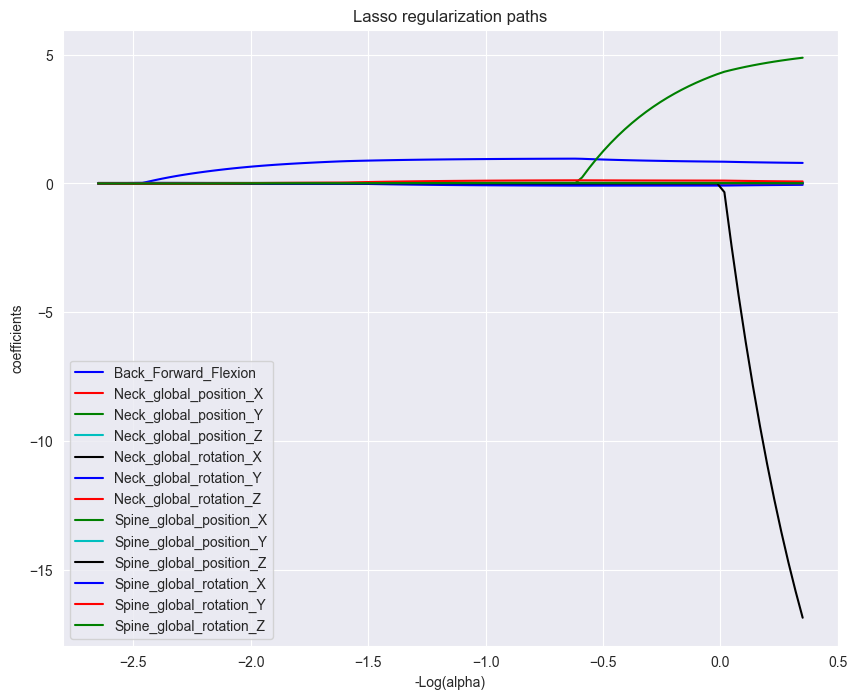

In [24]:
from itertools import cycle
colors = cycle(['b', 'r', 'g', 'c', 'k'])

plt.figure(figsize=[10,8])

neg_log_alphas_lasso = -np.log10(alphas_lasso)
for coef_l, col_name, c in zip(coefs_lasso, x_train.columns , colors):
    l1 = plt.plot(neg_log_alphas_lasso, coef_l, c=c, label=col_name )

plt.xlabel('-Log(alpha)')
plt.ylabel('coefficients')
plt.legend(loc='best')
plt.title('Lasso regularization paths')
plt.show();

Lasso regression did not exclude any factors. In normal linear regression, the coefficients of all the predictors are significant, it is reasonable that the Lasso does not force any factors to 0. However, we also have multicollinearity issues. Because the main goal was to make predictions instead of explanation, in the next, I want to use various ML algorithms such as regression tree and the neural network to see whether the prediction results will become better.

## 5. Use random forest and gradient boosting

5.1 Random forest

In [6]:
# Train a regression tree using Random forest algorithm
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer

In [12]:
# Define loss function, in this case the sum of squared errors
def sse(y_true, y_pred):
    return np.sum((y_true - y_pred) ** 2)

sse_scorer = make_scorer(sse, greater_is_better=False)

print('Tuning random forest regressor')

# Initialize the Random Forest Regressor
rf = RandomForestRegressor(random_state=123, max_samples=0.5, n_jobs=-1)  # Bootstrap sample size is 50% of the training set

# Define hyperparameter grid
param_dist = {
    'n_estimators': [10, 20, 50],
    'max_features': [1, 2, 3, 4],
    'max_depth': [None, 10, 20],
}

# Use RandomizedSearchCV to find the best hyperparameters
gs_rf_random = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=10,  # Number of random combinations to try
    cv=5,
    scoring=sse_scorer,
    verbose=1,
    random_state=123,
    error_score='raise'
)

# Fit the grid search object to the training data
gs_rf_random.fit(x_train, y_train)

# Get the best estimator and its parameters
best_rf = gs_rf_random.best_estimator_
print(f"Best parameters: {gs_rf_random.best_params_}")

# Initialize KFold for cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialize lists to store MSE for each fold
mse_train_list = []
mse_test_list = []

print("\nCross-validating the Random Forest model:")

for fold_idx, (train_idx, val_idx) in enumerate(kf.split(x_train, y_train)):
    # Split the data into training and validation sets for the current fold
    x_train_fold, x_val_fold = x_train.iloc[train_idx], x_train.iloc[val_idx]
    y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]

    # Train the Random Forest model on the current fold
    best_rf.fit(x_train_fold, y_train_fold)

    # Make predictions on the training and validation sets
    y_train_pred = best_rf.predict(x_train_fold)
    y_val_pred = best_rf.predict(x_val_fold)

    # Calculate MSE for the current fold
    mse_train = mean_squared_error(y_train_fold, y_train_pred)
    mse_test = mean_squared_error(y_val_fold, y_val_pred)

    # Append the MSE values to the respective lists
    mse_train_list.append(mse_train)
    mse_test_list.append(mse_test)

    # Print MSE for the current fold
    print(f"\tFold {fold_idx + 1}: MSE on Train Set = {mse_train:.4f}, MSE on Test Set = {mse_test:.4f}")

# Convert results to a DataFrame for easy analysis
mse_results_rf = pd.DataFrame({
    'Fold': np.arange(1, kf.get_n_splits() + 1),
    'MSE_Train': mse_train_list,
    'MSE_Test': mse_test_list
})

# Print average MSE across folds
avg_mse_train = np.mean(mse_train_list)
avg_mse_test = np.mean(mse_test_list)

print("\nCross-validation MSE Results for Random Forest:")
print(mse_results_rf)
print(f"\nAverage MSE on Train Set: {avg_mse_train:.4f}")
print(f"Average MSE on Test Set: {avg_mse_test:.4f}")

# Evaluate the best model on the hold-out test set
y_test_pred = best_rf.predict(x_test)
mse_test_final = mean_squared_error(y_test, y_test_pred)

print(f"\nFinal MSE on Hold-out Test Set: {mse_test_final:.4f}")

Tuning random forest regressor
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters: {'n_estimators': 50, 'max_features': 4, 'max_depth': None}

Cross-validating the Random Forest model:
	Fold 1: MSE on Train Set = 2.2966, MSE on Test Set = 6.0710
	Fold 2: MSE on Train Set = 2.2851, MSE on Test Set = 5.7396
	Fold 3: MSE on Train Set = 2.2978, MSE on Test Set = 5.9746
	Fold 4: MSE on Train Set = 2.2955, MSE on Test Set = 6.4125
	Fold 5: MSE on Train Set = 2.3186, MSE on Test Set = 5.9811

Cross-validation MSE Results for Random Forest:
   Fold  MSE_Train  MSE_Test
0     1   2.296561  6.071014
1     2   2.285147  5.739643
2     3   2.297784  5.974554
3     4   2.295516  6.412545
4     5   2.318638  5.981132

Average MSE on Train Set: 2.2987
Average MSE on Test Set: 6.0358

Final MSE on Hold-out Test Set: 6.1590


In terms of MSE, we can see that the value of random forest (MSE=6.05)is significantly lower than that of Lasso (MSE=56.22). The potential reason is that random forest forces the tree to be different, avoiding that the strongest predictor is always included in the model. In addition, the linear regression assumes that there is a linear relationship, while the random forest does not have such an assumption.

5.2 In the next, we try gradient boosting algorithm and see whether there is any improvement.

In [7]:
# Gradient boosting regression
from sklearn.ensemble import GradientBoostingRegressor

In [14]:
# Randomized parameter grid
xgb_param_dist = {
    'max_features': [None, 'sqrt', 'log2'],  # Random subspace
    'n_estimators': [100, 200],  # Ensemble size or number of boosting steps
    'max_depth': [5, 10],  # Max depth of decision trees
    'learning_rate': [0.1, 0.01],  # Learning rate
    'min_samples_split': [2,5]  # Min samples required to split an internal node
}

# Initialize Gradient Boosting Regressor
xgb = GradientBoostingRegressor()

# Use RandomizedSearchCV instead of GridSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=xgb_param_dist,
    n_iter=10,
    scoring='neg_mean_squared_error',
    cv=5,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# Fit the model to your training data
random_search.fit(x_train, y_train)

# Get the best model from the search
best_xgb = random_search.best_estimator_

# Print the best parameters and SSE
print(f"Best Parameters: {random_search.best_params_}")
print(f"Best Negative SSE: {-random_search.best_score_}")  # Negate the score for actual SSE

# Initialize KFold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialize lists to store MSE for each fold
mse_train_list = []
mse_test_list = []

print("\nCross-validating the Gradient Boosting model:")

for fold_idx, (train_idx, val_idx) in enumerate(kf.split(x_train, y_train)):
    # Split the data into training and validation sets for the current fold
    x_train_fold, x_val_fold = x_train.iloc[train_idx], x_train.iloc[val_idx]
    y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]

    # Train the best Gradient Boosting model on the current fold
    best_xgb.fit(x_train_fold, y_train_fold)

    # Make predictions on the training and validation sets
    y_train_pred = best_xgb.predict(x_train_fold)
    y_val_pred = best_xgb.predict(x_val_fold)

    # Calculate MSE for the current fold
    mse_train = mean_squared_error(y_train_fold, y_train_pred)
    mse_test = mean_squared_error(y_val_fold, y_val_pred)

    # Append the MSE values to the respective lists
    mse_train_list.append(mse_train)
    mse_test_list.append(mse_test)

    # Print MSE for the current fold
    print(f"\tFold {fold_idx + 1}: MSE on Train Set = {mse_train:.4f}, MSE on Test Set = {mse_test:.4f}")

# Convert results to a DataFrame for easy analysis
mse_results_xgb = pd.DataFrame({
    'Fold': np.arange(1, kf.get_n_splits() + 1),
    'MSE_Train': mse_train_list,
    'MSE_Test': mse_test_list
})

# Print average MSE across folds
avg_mse_train = np.mean(mse_train_list)
avg_mse_test = np.mean(mse_test_list)

print("\nCross-validation MSE Results for Gradient Boosting:")
print(mse_results_xgb)
print(f"\nAverage MSE on Train Set: {avg_mse_train:.4f}")
print(f"Average MSE on Test Set: {avg_mse_test:.4f}")

# Evaluate the best model on the hold-out test set
y_test_pred = best_xgb.predict(x_test)
mse_test_final = mean_squared_error(y_test, y_test_pred)

print(f"\nFinal MSE on Hold-out Test Set: {mse_test_final:.4f}")

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Parameters: {'n_estimators': 200, 'min_samples_split': 5, 'max_features': 'sqrt', 'max_depth': 10, 'learning_rate': 0.1}
Best Negative SSE: 5.804251377239991

Cross-validating the Gradient Boosting model:
	Fold 1: MSE on Train Set = 1.9764, MSE on Test Set = 5.9490
	Fold 2: MSE on Train Set = 2.0703, MSE on Test Set = 5.6471
	Fold 3: MSE on Train Set = 2.0815, MSE on Test Set = 5.7885
	Fold 4: MSE on Train Set = 2.0641, MSE on Test Set = 5.8747
	Fold 5: MSE on Train Set = 2.0363, MSE on Test Set = 5.8209

Cross-validation MSE Results for Gradient Boosting:
   Fold  MSE_Train  MSE_Test
0     1   1.976364  5.949044
1     2   2.070252  5.647065
2     3   2.081518  5.788478
3     4   2.064127  5.874748
4     5   2.036303  5.820854

Average MSE on Train Set: 2.0457
Average MSE on Test Set: 5.8160

Final MSE on Hold-out Test Set: 5.8540


The gradient boosting method took much more time than random forest for the training. For training the model, instead of using grid search, I used random search, which can reduce the training time. In terms of MSE, gradient boosting gives very good results up to now. Compared the MSE of RF (6.03), gradient boosting has the MSE of 5.81.

## 6. Use neural network

In [16]:
# Use neural network to train the model
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning

In [17]:
# Filter warning messages
simplefilter("ignore", category=ConvergenceWarning)

# Initialize the MLPRegressor
nn = MLPRegressor(random_state=888, max_iter=1000)

# Try using a neural network with one hidden layer and two hidden layers
parameter_space = {
    'hidden_layer_sizes': [(5,), (25,5)],
    'activation': ['tanh', 'relu'], # we try both tanh and relu, and let it select the best one
    'alpha': [0.1, 0.05],
}

# Set up the grid object specifying the tuning options
gs_nn = GridSearchCV(nn, parameter_space, cv=5, scoring='neg_mean_squared_error', verbose=1)
gs_nn.fit(x_train, y_train)

# Display the best parameters and best score
print("Best parameters found:", gs_nn.best_params_)

# Compute MSE and SSE on the training and testing sets
best_model = gs_nn.best_estimator_

# Initialize KFold for cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialize lists to store MSE for each fold
mse_train_list = []
mse_test_list = []

print("\nCross-validating the Neural Network model:")

for fold_idx, (train_idx, val_idx) in enumerate(kf.split(x_train, y_train)):
    # Split the data into training and validation sets for the current fold
    x_train_fold, x_val_fold = x_train.iloc[train_idx], x_train.iloc[val_idx]
    y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]

    # Train the best Neural Network model on the current fold
    best_model.fit(x_train_fold, y_train_fold)

    # Make predictions on the training and validation sets
    y_train_pred = best_model.predict(x_train_fold)
    y_val_pred = best_model.predict(x_val_fold)

    # Calculate MSE for the current fold
    mse_train = mean_squared_error(y_train_fold, y_train_pred)
    mse_test = mean_squared_error(y_val_fold, y_val_pred)

    # Append the MSE values to the respective lists
    mse_train_list.append(mse_train)
    mse_test_list.append(mse_test)

    # Print MSE for the current fold
    print(f"\tFold {fold_idx + 1}: MSE on Train Set = {mse_train:.4f}, MSE on Test Set = {mse_test:.4f}")

# Convert results to a DataFrame for easy analysis
mse_results_nn = pd.DataFrame({
    'Fold': np.arange(1, kf.get_n_splits() + 1),
    'MSE_Train': mse_train_list,
    'MSE_Test': mse_test_list
})

# Print average MSE across folds
avg_mse_train = np.mean(mse_train_list)
avg_mse_test = np.mean(mse_test_list)

print("\nCross-validation MSE Results for Neural Network:")
print(mse_results_nn)
print(f"\nAverage MSE on Train Set: {avg_mse_train:.4f}")
print(f"Average MSE on Test Set: {avg_mse_test:.4f}")

# Evaluate the best model on the hold-out test set
y_test_pred = best_model.predict(x_test)
mse_test_final = mean_squared_error(y_test, y_test_pred)

print(f"\nFinal MSE on Hold-out Test Set: {mse_test_final:.4f}")

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters found: {'activation': 'relu', 'alpha': 0.1, 'hidden_layer_sizes': (25, 5)}

Cross-validating the Neural Network model:
	Fold 1: MSE on Train Set = 25.0893, MSE on Test Set = 25.8964
	Fold 2: MSE on Train Set = 25.2420, MSE on Test Set = 25.1679
	Fold 3: MSE on Train Set = 27.0294, MSE on Test Set = 27.8247
	Fold 4: MSE on Train Set = 30.2542, MSE on Test Set = 31.2635
	Fold 5: MSE on Train Set = 29.7439, MSE on Test Set = 29.9507

Cross-validation MSE Results for Neural Network:
   Fold  MSE_Train   MSE_Test
0     1  25.089300  25.896427
1     2  25.242029  25.167898
2     3  27.029413  27.824688
3     4  30.254217  31.263535
4     5  29.743898  29.950687

Average MSE on Train Set: 27.4718
Average MSE on Test Set: 28.0206

Final MSE on Hold-out Test Set: 30.1270


## 7. Use recurrent neural network

In [18]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential

In [20]:
# We give each sample a time step
X = np.expand_dims(X, axis=-1)

# Standardize the data
scaler = StandardScaler()

# Reshape to 2D for scaling: [samples * time_steps, features]
X_reshaped = X.reshape(-1, X.shape[-1])

# Fit and transform the training data, and transform the test data
X_reshaped = scaler.fit_transform(X_reshaped)

# Reshape back to 3D: [samples, time_steps, features]
X = X_reshaped.reshape(-1, X.shape[1], X.shape[2])

# KFold cross-validation
nfold = 5
kf = KFold(n_splits=nfold, shuffle=True, random_state=42)

# Store results for each fold
results_cv = []

# Start KFold cross-validation
for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
    print(f"\nTraining fold {fold + 1}/{nfold}...")

    # Split data into training and validation sets for this fold
    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    # Create the GRU model
    gru = models.Sequential()
    gru.add(layers.GRU(16, input_shape=(X_train.shape[1], X_train.shape[2])))  # GRU layer
    gru.add(layers.Dense(32, activation='relu'))  # Dense layer
    gru.add(layers.Dense(1, activation='linear'))  # Output layer (linear activation for regression)

    # Compile the model
    gru.compile(loss="mean_squared_error", optimizer="adam", metrics=["mse"])

    # Train the model
    gru.fit(X_train, y_train, epochs=30, batch_size=64, verbose=1)

    # Evaluate the model on the validation set
    val_loss, val_mse = gru.evaluate(X_val, y_val, verbose=0)
    print(f"Fold {fold + 1} - Validation Loss: {val_loss:.4f}, Validation MSE: {val_mse:.4f}")

    # Store the result of this fold
    results_cv.append((val_loss, val_mse))

# After all folds, calculate the average results
avg_val_loss = np.mean([result[0] for result in results_cv])
avg_val_mse = np.mean([result[1] for result in results_cv])

print(f"Average Validation MSE: {avg_val_mse:.4f}")



Training fold 1/5...
Epoch 1/30


C:\Users\zheng\PycharmProjects\ML_homework\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1846/1846 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 193.9493 - mse: 193.9493
Epoch 2/30
1846/1846 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 72.1423 - mse: 72.1423
Epoch 3/30
1846/1846 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 68.8956 - mse: 68.8956
Epoch 4/30
1846/1846 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 66.0415 - mse: 66.0415
Epoch 5/30
1846/1846 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 64.1573 - mse: 64.1573
Epoch 6/30
1846/1846 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 62.9659 - mse: 62.9659
Epoch 7/30
1846/1846 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 62.1965 - mse: 62.1965
Epoch 8/30
1846/1846 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 60.6615 - mse: 60.6615
Epoch 9/30
1846/1846 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 60.2263 - mse: 60.2263
Epoch 10/30
1846/1846 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 58.9911 - mse: 58.9911
Epoch 11/30
1846/1846 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 57.6392 - mse: 57.6392
Epoch 12/30
1846/1846 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 56.9276 -

Recurrent neural network did not provide very good results in terms of MSE. The test result is similar to that of normal linear regression.

## 8. Summary

I summarize the MSE values of various ML algorithms below:

Multiple linear regression: 56,45

Multiple linear regression with Lasso: 56,58

Random forest: 5,816

Gradient boosting: 5,82

Neural network: 28,02

Recurrent neural network: 49,24

The results show that Random forest and Gradient boosting lead to the best prediction results. However, there are several issues to mention. First, In regression analysis, multicollinearity issue was found, in a next step, I want to combine/eliminate highly correlated predictors, and see whether it lead to better results. Second, I was expecting that the recurrent neuralnetwork would lead to better results, because the data used in this notebook is actually sequential data. However, the result seems not so ideal, perhaps the epochs need to be set higher? Third, because the data used in this notebook are all collected from the lab, in a next step, I want to use the trained random forest model and gradient boosting model to test the data collected from the field to see how the result will be. Lastly, there are actually several body joints captured by the Kinect and Captiv systems, in a next step, I'd lke to train model for different body parts.